In [ ]:
#Installing Packages
!pip install stable-baselines3
!pip install SALib

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 14.7 MB/s eta 0:00:00


In [ ]:
#Importing libraries and modules
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import pandas as pd

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

**Load and Preprocess Solar Power Data**

In [ ]:
# Uploading CSV file
from google.colab import files
import io

uploaded = files.upload()

Saving SolarProfile.csv to SolarProfile (2).csv


In [ ]:
# Read the solar data CSV file
solar_data = pd.read_csv('SolarProfile (2).csv')

# Preprocess data with the correct format (month/day/year)
solar_data['DATE_TIME'] = pd.to_datetime(solar_data['DATE_TIME'], format='%m/%d/%Y %H:%M')

# Filter data for operating time (6am to 6pm)
solar_data_daytime = solar_data[(solar_data['DATE_TIME'].dt.hour >= 6) & (solar_data['DATE_TIME'].dt.hour < 18)]
# Keep only DATE_TIME and DC_POWER
daytime_solar_data = solar_data_daytime[['DATE_TIME', 'DC_POWER']]

print("Processed Solar Data Information:")
print(daytime_solar_data.info())
print("\nFirst few rows:")
print(daytime_solar_data.head())

Processed Solar Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 35144 entries, 510 to 68249
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE_TIME  35144 non-null  datetime64[ns]
 1   DC_POWER   35144 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 823.7 KB
None

First few rows:
              DATE_TIME   DC_POWER
510 2020-05-15 06:00:00  37.142857
511 2020-05-15 06:00:00  53.500000
512 2020-05-15 06:00:00  58.000000
513 2020-05-15 06:00:00  58.428571
514 2020-05-15 06:00:00  54.375000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


**PEM Electrolyser Environment Setup**

Action: delta current density (A/cm^2) in [-0.2,0.2]

Reward: 0.6* efficiency +0.3 * safety - 0. 1* instability

In [ ]:
class ElectrolyserEnv(gym.Env):

    metadata = {"render_modes": []} # The environment does not support rendering

    def __init__(self, episode_len=600, seed: int | None = None, solar_series=None):
        super().__init__()
        self.episode_len = episode_len
        self.rng = np.random.default_rng(seed)  # Random number generator for variability
        self.t = 0                              # Time step counter
        self.state = None                       # Initial state
        self.solar = solar_series               # optional array of solar power availability

        # Define action space for control of current density
        self.action_space = spaces.Box(low=-0.2, high=0.2, shape=(1,), dtype=np.float32)

        # Define the observation space: voltage, current density, temperature, pressure, flow rate, and power input
        self.observation_space = spaces.Box(
            low=np.array([1.2, 0.0,  20.0, 0.5, 0.0,   0.0], dtype=np.float32),
            high=np.array([2.4, 3.0, 100.0, 40.0, 120.0, 1.0], dtype=np.float32),
            dtype=np.float32
        )

        # Define target and safety boundaries for system operation
        self.v_opt = 1.8
        self.j_min, self.j_max = 0.1, 2.0
        self.v_min, self.v_max = 1.6, 2.0

    # Gymnasium-style seeding
    def seed(self, seed=None):
        self.rng = np.random.default_rng(seed)

    def _initial_state(self):
        voltage = self.v_opt + self.rng.normal(0, 0.02) # Voltage with small noise
        j = self.rng.uniform(0.3, 0.8)      # A/cm^2
        temp = self.rng.uniform(45, 60)     # °C
        press = self.rng.uniform(5, 10)     # bar
        flow = self.rng.uniform(10, 20)     # g/s
        if self.solar is None:
            power_in = self.rng.uniform(0.3, 0.8)  # normalised renewable availability
        else:
            power_in = float(np.clip(self.solar[self.t % len(self.solar)], 0, 1))
        return np.array([voltage, j, temp, press, flow, power_in], dtype=np.float32)

    def reset(self, *, seed=None, options=None):   # Reset base environment state
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)                        # Set the random seed if provided
        self.t = 0                                 # Reset time step
        self.state = self._initial_state()         # Initialise the state
        return self.state.copy(), {}               # Return the state and an empty info dictionary

    def step(self, action):
        self.t += 1                                # Increment time step
        s = self.state.copy()                      # Copy the current state
        a = float(np.clip(action[0], self.action_space.low[0], self.action_space.high[0]))   # Clip action within limits

        v, j, temp, press, flow, pin = s                               # Extract state variables

        # Update state variables based on dynamics and action
        j = np.clip(j + a, self.j_min, self.j_max)                            # Update current density based on action
        v = np.clip(1.5 + 0.18*j + self.rng.normal(0, 0.01), 1.2, 2.4)        # voltage increases with current density
        temp = np.clip(temp + 0.05*j + self.rng.normal(0, 0.1), 20, 100)      # Temperature response to current density
        press = np.clip(press + 0.02*j + self.rng.normal(0, 0.05), 0.5, 40)   # Pressure response to current density
        flow  = np.clip(flow + 0.5*j  + self.rng.normal(0, 0.5), 0, 120)      # Flow rate response to current density

        # Solar power input (if available) or a sinusoidal function
        if self.solar is None:
            pin = np.clip(0.6 + 0.3*np.sin(self.t/50) + self.rng.normal(0, 0.03), 0, 1)
        else:
            idx = self.t % len(self.solar)
            pin = float(np.clip(self.solar[idx], 0, 1))

        next_state = np.array([v, j, temp, press, flow, pin], dtype=np.float32)  # Compute next state

        # Reward calculation
        efficiency = np.clip(j / self.j_max, 0, 1) * pin
        safety_pen = 0.0
        if v < self.v_min or v > self.v_max: safety_pen += 1.0
        if j < self.j_min or j > self.j_max: safety_pen += 1.0
        safety = 1.0 - safety_pen     # 1 if safe, lower if violating
        instability = abs(v - self.v_opt)

        reward = 0.6*efficiency + 0.3*safety - 0.1*instability  #total reward

        # Update state and check for termination
        self.state = next_state
        terminated = False                           # Episode termination (for now, never True)
        truncated = self.t >= self.episode_len       # Episode ends when the time step exceeds episode length
        info = {}                                    # Empty info dictionary
        return next_state, float(reward), terminated, truncated, info

**PID CONTROLLER**

In [ ]:
class PID:
    def __init__(self, kp, ki, kd, u_min=-0.2, u_max=0.2):
        self.kp, self.ki, self.kd = kp, ki, kd  # Initialise PID gains
        self.u_min, self.u_max = u_min, u_max   # Control output limits
        self.i = 0.0                            # Initialise integral term
        self.prev_e = 0.0                       # Initialise previous error

    def reset(self):
        self.i, self.prev_e = 0.0, 0.0          # Reset integral and previous error to 0

    def __call__(self, setpoint, measured):
        e = setpoint - measured                          # Calculate the current error
        self.i += e                                      # Integral of the error
        d = e - self.prev_e                              # Derivative of the error
        self.prev_e = e                                  # Update the previous error for the next step
        u = self.kp*e + self.ki*self.i + self.kd*d       # Compute the control signal using the PID formula
        return float(np.clip(u, self.u_min, self.u_max)) # Clip the control signal to stay within the specified limits and return it

**Training PPO Model**

In [ ]:
make_env = lambda: ElectrolyserEnv(episode_len=600, seed=42)
vec_env = DummyVecEnv([make_env])    # Wrapper that allows the environment to be used with Stable-Baselines3 algorithms

#Hyperparamters for the PPO Model
model = PPO(
    "MlpPolicy",
    vec_env,
    learning_rate=3e-4,
    clip_range=0.3,
    ent_coef=0.01,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    policy_kwargs={"net_arch": [64, 64]},
    verbose=1,
)

# Start the training process
# The model is trained using the PPO algorithm for a total of 50,000 timesteps
model.learn(total_timesteps=50_000)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1175 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 742         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.028176155 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.3         |
|    entropy_loss         | -1.4        |
|    explained_variance   | -0.0135     |
|    learning_rate        | 0.0003      |
|    loss                 | 5.42        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0197     |
|    std                  | 0.971       |
|    value_loss           | 13.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 727         |
|    iterations           | 3           |
|    time_elapsed         | 8     

In [ ]:
#Performance Comparison
def run_policy(env: ElectrolyserEnv, policy_fn, episodes=10, deterministic=True):
    returns = [] # List to store total reward for each episode
    for ep in range(episodes):
        # Reset the environment for a new episode and get the initial observation
        obs, _ = env.reset(seed=1000+ep)
        done = trunc = False
        total = 0.0  # Total reward for this episode
        while not (done or trunc):
            # Get the action from the policy function
            act = policy_fn(obs, deterministic=deterministic)
            if isinstance(act, tuple):
                act = act[0]
            # Apply the action to the environment and get the next state, reward, and termination flags
            obs, r, done, trunc, _ = env.step(np.array([act], dtype=np.float32))
            total += r        # Accumulate the reward for this step
        returns.append(total) # Append the total reward for this episode
    return np.array(returns)  # Return the rewards for all episodes as a numpy array

# Define PPO policy function
def ppo_action(obs, deterministic=True):
    a, _ = model.predict(obs, deterministic=deterministic)  # Get action from the PPO model
    return float(a[0])  # Return the action as a float

# Define the PID controller function
pid = PID(kp=1.2, ki=0.01, kd=0.2)        # Create a PID controller with specific gains
def pid_action(obs, deterministic=True):
    v = float(obs[0])                       # Extract voltage from the observation
    return pid(1.8, v)                      # Compute the action to bring the voltage to 1.8 using PID control

# Initialize the environment for testing
test_env = ElectrolyserEnv(episode_len=600, seed=7)
# Reset PID controller before running tests
pid.reset()
# Run PPO policy on the environment for 20 episodes and collect scores
ppo_scores = run_policy(test_env, ppo_action, episodes=20)
# Reset PID controller before running tests
pid.reset()
# Run PID control on the environment for 20 episodes and collect scores
pid_scores = run_policy(test_env, pid_action, episodes=20)

# Mean episode returns for both policies
print("PPO mean episode return:", ppo_scores.mean())
print("PID mean episode return:", pid_scores.mean())

PPO mean episode return: 392.78097162682224
PID mean episode return: 360.38023532071355


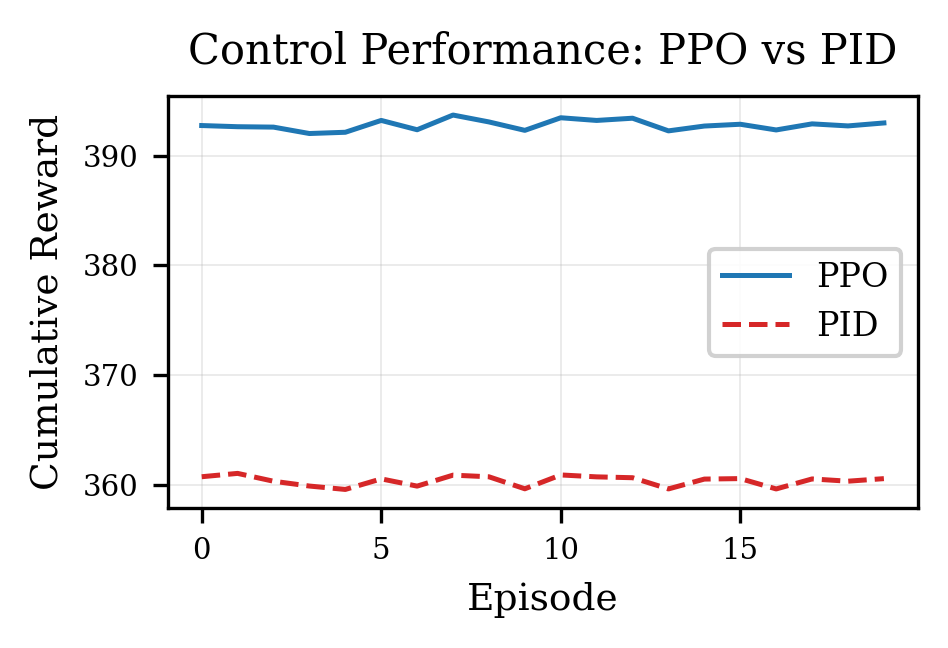

In [ ]:
#Plot Appearance
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 8,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'figure.dpi': 300,
})

plt.figure(figsize=(3.2, 2.2))

# Plot the data
plt.plot(ppo_scores, label="PPO", linewidth=1.2, color='#1f77b4')
plt.plot(pid_scores, label="PID", linewidth=1.2, color='#d62728', linestyle='--')

# Labels and title
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Control Performance: PPO vs PID", pad=8)

# Legend and grid
plt.legend(frameon=True, framealpha=0.9, edgecolor='0.8')
plt.grid(True, alpha=0.3, linewidth=0.4)

plt.tight_layout()
plt.show()

**PPO LEARNING CURVE**

In [ ]:
#PPO learning curve
eval_every = 5_000
total_steps = 50_000
eval_episodes = 5

learning_steps = []
learning_scores = []

eval_env = ElectrolyserEnv(episode_len=600, seed=123)

steps_done = 0
while steps_done < total_steps:
    model.learn(total_timesteps=eval_every, reset_num_timesteps=False, progress_bar=False)
    steps_done += eval_every

    def ppo_action(obs, deterministic=True):
        a, _ = model.predict(obs, deterministic=deterministic)
        return float(a[0])

    scores = []
    for k in range(eval_episodes):
        obs, _ = eval_env.reset(seed=10_000 + k)
        done = trunc = False
        total = 0.0
        while not (done or trunc):
            act = ppo_action(obs, deterministic=True)
            obs, r, done, trunc, _ = eval_env.step(np.array([act], dtype=np.float32))
            total += r
        scores.append(total)

    learning_steps.append(steps_done)
    learning_scores.append(np.mean(scores))

------------------------------
| time/              |       |
|    fps             | 1173  |
|    iterations      | 1     |
|    time_elapsed    | 1     |
|    total_timesteps | 53248 |
------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 700           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 55296         |
| train/                  |               |
|    approx_kl            | 0.00052570645 |
|    clip_fraction        | 0.00146       |
|    clip_range           | 0.3           |
|    entropy_loss         | -1.31         |
|    explained_variance   | 0.951         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.37          |
|    n_updates            | 260           |
|    policy_gradient_loss | -0.000391     |
|    std                  | 0.894         |
|    value_loss           | 1.05   

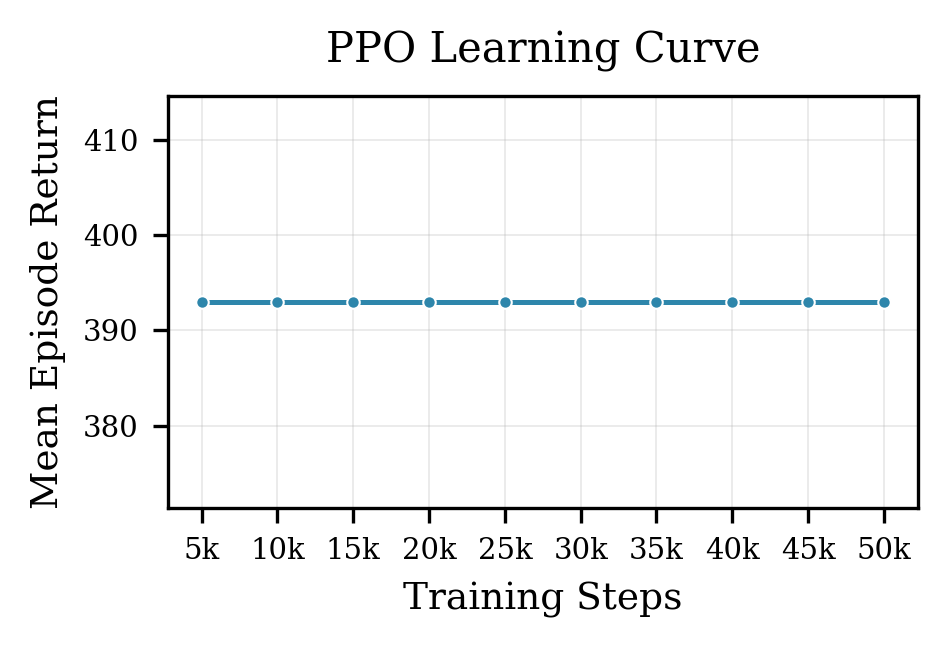

In [ ]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 8,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'figure.dpi': 300,
})

plt.figure(figsize=(3.2, 2.2))

# Plot learning curve
plt.plot(learning_steps, learning_scores, marker="o", markersize=3,
         linewidth=1.2, color='#2E86AB', markerfacecolor='#2E86AB',
         markeredgecolor='white', markeredgewidth=0.5)

# Labels and title
plt.xlabel("Training Steps")
plt.ylabel("Mean Episode Return")
plt.title("PPO Learning Curve", pad=8)

plt.grid(True, alpha=0.3, linewidth=0.4)

# X Axis
if max(learning_steps) >= 10000:
    plt.gca().set_xticks(learning_steps)
    plt.gca().set_xticklabels([f'{x//1000}k' if x >= 1000 else str(x) for x in learning_steps])


plt.tight_layout()
plt.show()

**Voltage Tracking**

In [ ]:
episode_len = 600  #length of each episode
trace_env = ElectrolyserEnv(episode_len=episode_len, seed=7)  # Initialise the environment for voltage tracking

# Function to trace voltage over an episode for a given controller
def trace_controller(env, controller_fn, label):
    obs, _ = env.reset(seed=2024)                # Reset environment with a specific seed for reproducibility
    done = trunc = False                         # Termination and truncation flags
    V = []                                       # List to store voltage values at each timestep
    while not (done or trunc):
        act = controller_fn(obs)                                                 # Get action from the controller function
        obs, r, done, trunc, _ = env.step(np.array([act], dtype=np.float32))     # Step the environment
        V.append(float(obs[0]))                                                  # voltage is state[0]
    return np.array(V)  # Return voltage as a numpy array

def ppo_ctrl(obs):
    a, _ = model.predict(obs, deterministic=True)        # Use deterministic action
    return float(a[0])                                   # Reset integral and previous error

pid = PID(kp=1.2, ki=0.01, kd=0.2)
pid.reset()
def pid_ctrl(obs):
    v = float(obs[0])                       # Extract voltage from observation
    return pid(1.8, v)                      # Compute PID control action


V_ppo = trace_controller(trace_env, ppo_ctrl, "PPO")           # Trace voltage using PPO controller
# Trace voltage using PID controller
trace_env2 = ElectrolyserEnv(episode_len=episode_len, seed=7)
pid.reset()                                                    # Reset PID before tracing again
V_pid = trace_controller(trace_env2, pid_ctrl, "PID")

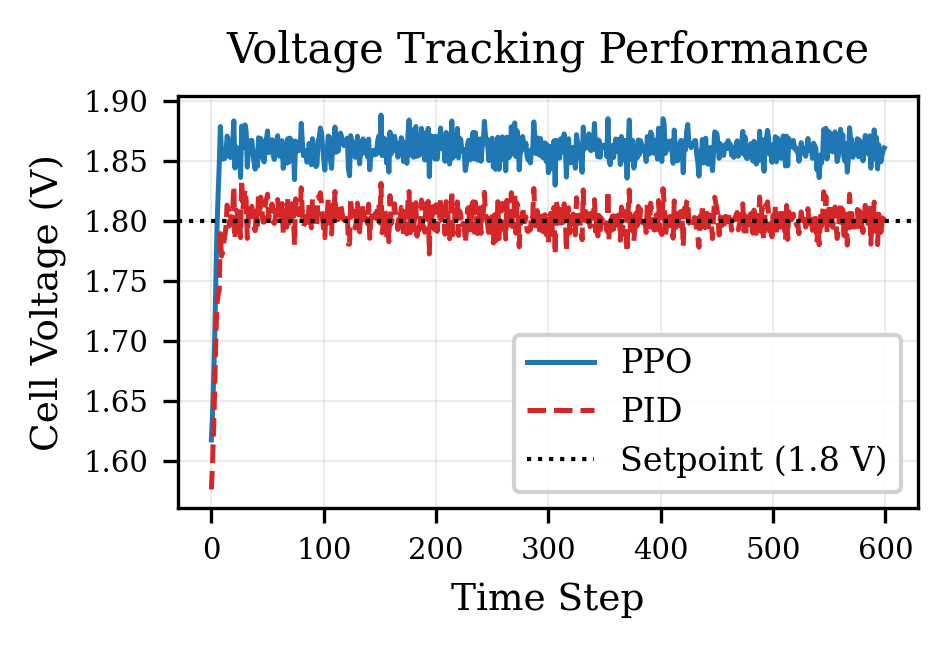

In [ ]:
#Plot Appearance
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 8,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'figure.dpi': 300,
})

plt.figure(figsize=(3.2, 2.2))
t = np.arange(len(V_ppo))  # Add this line!

# Voltage Trajectories
plt.plot(t, V_ppo, label="PPO", linewidth=1.2, color='#1f77b4')
plt.plot(t, V_pid, label="PID", linewidth=1.2, color='#d62728', linestyle='--')
plt.axhline(1.8, linestyle=":", color='black', linewidth=1.0, label="Setpoint (1.8 V)")

# Labels and title with units
plt.xlabel("Time Step")
plt.ylabel("Cell Voltage (V)")
plt.title("Voltage Tracking Performance", pad=8)

# Legend and grid
plt.legend(frameon=True, framealpha=0.9, edgecolor='0.8')
plt.grid(True, alpha=0.3, linewidth=0.4)


plt.tight_layout()
plt.show()

**Hydrogen Production Efficiency**

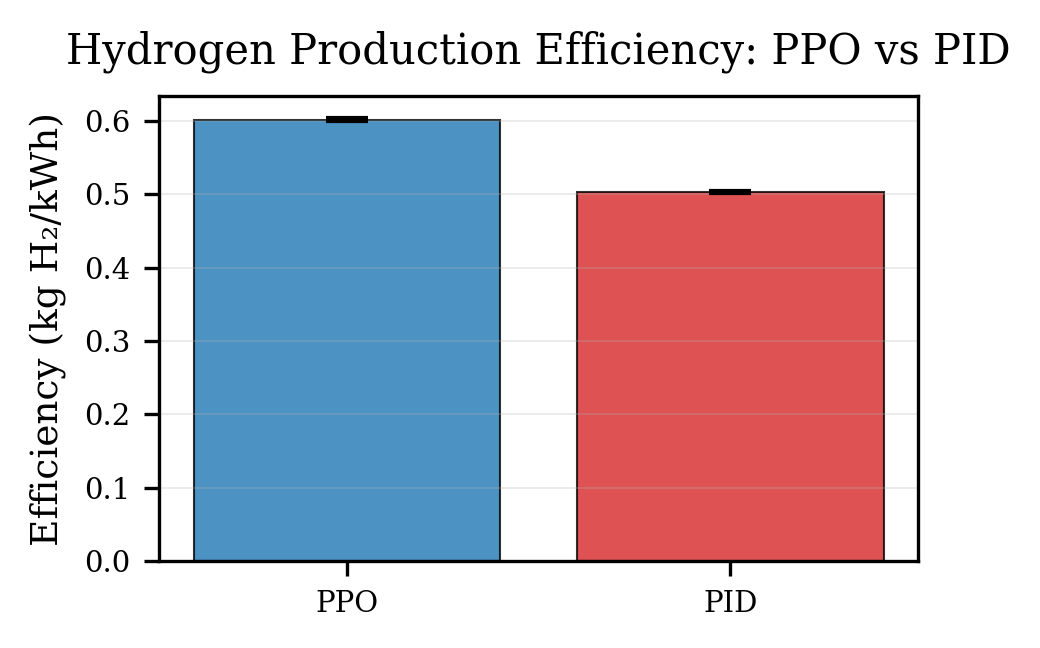

PPO efficiency: 0.602 ± 0.002
PID efficiency: 0.504 ± 0.001


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Function to run a controller and collect mean efficiency per episode
def run_and_collect_efficiency(env_seed, controller_fn, episodes=20):
    env = ElectrolyserEnv(episode_len=600, seed=env_seed)  # Initialize environment
    eff_means = []                                         # List to store mean efficiency for each episode
    for ep in range(episodes):
        obs, _ = env.reset(seed=50_000 + ep)               # Reset environment with unique seed
        done = trunc = False
        eff_values = []                                    # List to store efficiency values for each timestep
        j_max = env.j_max                                  # Maximum current density for normalization
        while not (done or trunc):
            act = controller_fn(obs)                       # Get action from the controller function
            obs, r, done, trunc, _ = env.step(np.array([act], dtype=np.float32))
            v, j, temp, press, flow, pin = obs             # Unpack state
            # Compute efficiency at this timestep
            eff = np.clip(j / j_max, 0, 1) * pin
            eff_values.append(float(eff))
        eff_means.append(np.mean(eff_values))             # Mean efficiency for this episode
    return np.array(eff_means)

#Controller functions
def ppo_ctrl(obs):
    a, _ = model.predict(obs, deterministic=True)
    return float(a[0])

pid = PID(kp=1.2, ki=0.01, kd=0.2)                         # PID controller initialization
def pid_ctrl(obs):
    v = float(obs[0])
    return pid(1.8, v)

# Run simulations and collect efficiency
pid.reset()
ppo_eff = run_and_collect_efficiency(123, ppo_ctrl, episodes=20)
pid.reset()
pid_eff = run_and_collect_efficiency(123, pid_ctrl, episodes=20)

# Plot appearance
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 8,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'figure.dpi': 300,
})

plt.figure(figsize=(3.2, 2.2))

# Bar chart with error bars
labels = ["PPO", "PID"]
means = [ppo_eff.mean(), pid_eff.mean()]
stds  = [ppo_eff.std(),  pid_eff.std()]

x = np.arange(len(labels))
plt.bar(x, means, yerr=stds, capsize=5, alpha=0.8,
        color=['#1f77b4', '#d62728'], edgecolor='black', linewidth=0.5)

plt.xticks(x, labels)
plt.ylabel("Efficiency (kg H₂/kWh)")
plt.title("Hydrogen Production Efficiency: PPO vs PID", pad=8)
plt.grid(True, axis="y", alpha=0.3, linewidth=0.4)

plt.tight_layout()
plt.show()

# Statistical summary
print(f"PPO efficiency: {means[0]:.3f} ± {stds[0]:.3f}")
print(f"PID efficiency: {means[1]:.3f} ± {stds[1]:.3f}")